# 1. What Climate Change Risks Are?

We could have began with a long and boring introduction about climate change risks, making a long lists about climate change issues. Basically, we could read one of the many report about it, like the one from the **Task-Force on Climate-Related Financial Disclosures** (TCFD). 

But let's take another option, and leverage on new AI capabilities to help us understand better the topic. In this first lesson, we will try to understand a bit better what climate change risks are by using **Natural Language Processing** (NLP).

To do so, we want:
- to **extract keywords characterizing climate change risks** issues;
- starting from this institutional climate change risks vocabulary, understands how does it **reflects in firms communication with earning calls transcripts**;
- finally, we'll build a **taxonomy of firms climate change risks exposure**

## A. Get Climate Change Risks Vocabulary


In [ ]:
from IPython.display import Image

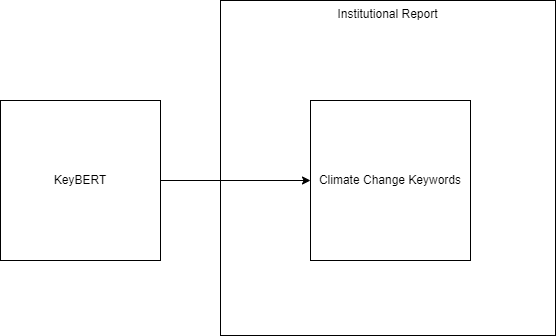

In [ ]:
Image('test.drawio.png')


When we want to understand key information from specific documents, we turn towards **keyword extraction**. It corresponds to the automated process of extracting the words and phrases that are most relevant.

We will rely on **KeyBERT** package, allowing us to easily extract keywords from a document and play with parameters in order to choose between keywords representativity or diversification.

### A.1. A First Taste of Climate Change Risks

To get a first taste of climate change risks keywords, let's try to extract keywords on a short piece of text extracted from a TCFD report.

In [ ]:
!pip install keybert #for installation purposes

In [ ]:
doc = """
Physical risks resulting from climate change can be event driven (acute) or longer-term shifts 
(chronic) in climate patterns. Physical risks may have financial implications for organizations, such 
as direct damage to assets and indirect impacts from supply chain disruption. Organizations’ 
financial performance may also be affected by changes in water availability, sourcing, and quality; 
food security; and extreme temperature changes affecting organizations’ premises, operations, 
supply chain, transport needs, and employee safety.
"""

In [ ]:
from keybert import KeyBERT
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud

kw_model = KeyBERT()
keywords = kw_model.extract_keywords(doc)
wc = WordCloud(background_color="white",width=1000,height=1000, max_words=10,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(dict(keywords))
plt.imshow(wc)

Okay, so what does this first rough approach tells us?
This piece of text seems to be about **climate**, **risks**, **impacts** and **disruption** on **organizations**. Maybe should we try by allowing keyphrases with multiple words?

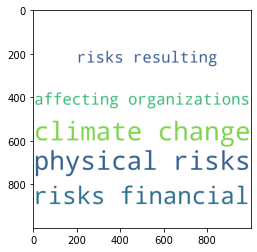

In [ ]:
keywords = kw_model.extract_keywords(doc, keyphrase_ngram_range = (1,2), stop_words = 'english')
wc = WordCloud(background_color="white",width=1000,height=1000, max_words=10,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(dict(keywords))
plt.imshow(wc)

Seems a bit more interesting! This piece of text seems to describe **physical risks** resulting from **climate change** and **affecting organizations**! Could be a good idea to highlight these keywords in the document itself, no?

In [ ]:
keywords = kw_model.extract_keywords(doc,keyphrase_ngram_range = (1,2), stop_words = 'english', highlight = True)

Physical risks from climate change be event driven acute or longer term shifts chronic in climate patterns Physical
risks have financial implications for organizations such as direct damage to assets and indirect impacts from 
supply chain disruption Organizations financial performance may also be affected by changes in water availability 
sourcing and quality food security and extreme temperature changes affecting organizations operations supply chain 
transport needs and employee safety

Nice, it looks like if someone did the review for us! But the result still quite vague, can we have more specifics examples highlighted?

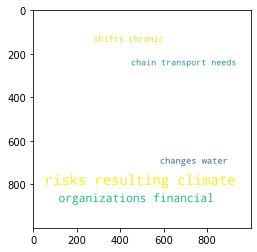

In [ ]:
keywords = kw_model.extract_keywords(doc, keyphrase_ngram_range = (2,3), stop_words = 'english',
                                     use_mmr = True, diversity = 0.7)
wc = WordCloud(background_color="white",width=1000,height=1000, max_words=10,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(dict(keywords))
plt.imshow(wc)

Okay so what's we've done there? We've played with the range of keywords allowed and use the Maximal Marginal Relevance method to increase the diversity of our keywords. Don't bother with the technical aspects, but you can see we are facing **an arbitrage here between diversification of our keywords and similarity of those keywords with the text (represented by the size of our keywords in the wordcloud**).

**Exercise:**
**Copy paste a paragraph from a report in the TCFD website and try to fine-tune the various parameters to get something sensible!**

In [ ]:
# To do:
# instantiate a 'doc' variable and copy paste your paragraph as a string
# try to use the functions seen above and print the resulting wordcloud

### A.2. Working with a Report

Let's now try to apply this method on a full report! To do so, we need to install and use the package **PyPDF2** in order to extract the text of the report.

In [ ]:
!pip install PyPDF2

In [ ]:
import PyPDF2

#Define path to PDF file
pdf_file_name = 'FINAL-2017-TCFD-Report-11052018.pdf'

reader = PyPDF2.PdfFileReader(pdf_file_name)

output = ""
for i in range(reader.numPages):
    pageObj = reader.getPage(i)
    output += pageObj.extractText()

print(len(output))
print(type(output))

241590
<class 'str'>


Because there is a limit of size of the document we can proceed, we will simply split the document evenly to transform it as a list of document.

In [ ]:
def split_even(item, split_num):
    return [item[i:i+split_num] for i in range(0, len(item), split_num)]

text = split_even(output, 512)
print(len(text))
print(text[300])

472
ts.   
The Task Force acknowledges the challenges and limitations of current carbon footprinting 
metrics, including that such metrics should not necessari ly be interpreted as risk metrics . 
Nevertheless, the Task Force views the reporting of weighted average carbon intensity as a first 
step and expects disclosure of this information to prompt important advancements in the 
development of decision -useful, clim ate-related risk metrics.  In this regard, the Task Force 
encourages asset owners and asset m


Before going further, let's have a quick overview of what KeyBERT is doing under the hoods:

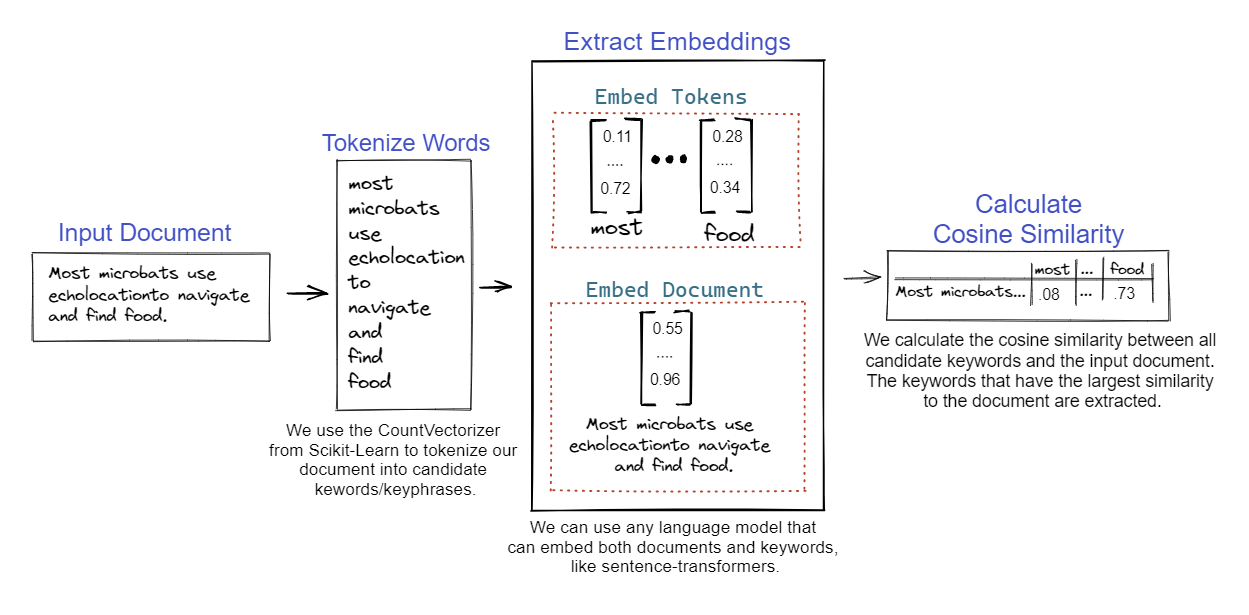

In [ ]:
from IPython.display import Image
Image('keybert.PNG')

As explained is this nice chart taken from the package documentation, our document is tokenized (transformed into list of words / group of words) and then processed by a language model to be converted in words embeddings and document embedding (that is transformed into numerical vectors). Then the keywords are selected according to their similarity to the entire document with the cosine similarity. 
What we will do next is to process our list of documents (our approximate paragraphs), extract the keywords associated and keep the most frequents.

We will proceed with a better vectorizer, thanks to the package KeyPhraseVectorizers. Using spacy for part-of-speech tagging, it will help us to figure out the best candidates keyphrases.

In [ ]:
!pip install keyphrase-vectorizers

In [ ]:
from keyphrase_vectorizers import KeyphraseCountVectorizer

# Extract candidate words/phrases
vectorizer = KeyphraseCountVectorizer(stop_words='english', spacy_pipeline = 'en_core_web_sm').fit(text)

As before, we then apply the model to extract keywords. It will results in a list of lists of tuples: one for each document.

In [ ]:
import numpy as np
keywords_doc = kw_model.extract_keywords(text, 
                                         stop_words="english", 
                                         vectorizer = vectorizer,
                                     top_n = 100, use_mmr = True, diversity = 0.7)

We then transform this list of lists of tuples as list of dictionnaries, and process it in order to compute the mean per keyphrase and finally retrieve the 100 keyphrases with the higher similarity with the documents.

[('industry task force', 0.519), ('climate issues', 0.4723), ('climate', 0.467), ('key climate', 0.4553), ('carbon economy', 0.3833), ('industry', 0.3729), ('consulting', 0.3575), ('companies', 0.3314), ('task force', 0.3142), ('task', 0.2699), ('economy', 0.2497), ('financial leaders', 0.2411), ('carbon', 0.2403), ('business', 0.2376), ('response', 0.2185), ('draft report', 0.2185), ('related information', 0.2177), ('information', 0.208), ('report', 0.2037), ('recommendations', 0.2034), ('financial', 0.1957), ('consideration', 0.1737), ('feedback', 0.1499), ('issues', 0.1458), ('draft', 0.1456), ('allocation', 0.1368), ('wide range', 0.1359), ('capital', 0.1165), ('months', 0.114), ('efficient allocation', 0.1121), ('transition', 0.1102), ('range', 0.0756), ('force', 0.0428)]


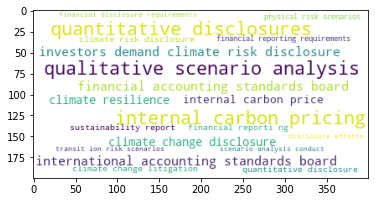

In [ ]:
keywords = [dict(keywords_doc[i]) for i in range(len(keywords_doc))]

my_result = dict()
for sub in keywords:
   for key, val in sub.items():
      if key in my_result:

         my_result[key].append(val)
      else:
         my_result[key] = [val]

for key, my_val in my_result.items():
   my_result[key] = np.mean(my_val)

list_k = sorted(my_result, key=my_result.get, reverse=True)[:100]
d1 = {k: my_result[k] for k in list_k}
wc = WordCloud(background_color="white", max_words=20,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(d1)
plt.imshow(wc)

Looks like we get a sense of the report, no? 

**Exercise:**
**Identify keyphrases in the reports regarding Physical risks and Transition risks**

## B. How does Firms Talk About Their Climate Change Risks Exposure?

### B.1. Earnings Call Transcripts

### B.2. Guided Topic Modelling

## C. A Taxonomy of Firms Climate Change Risks Exposure

### C.1. Hierarchical Topic Modelling